In [2]:
%reload_ext autoreload
%autoreload 2
%run startup.py

ag_ha = attrgetter(*'t v_0 v_c v_1 a_max'.split())
ag = attrgetter(*'x t v_0 v_c v_1 v_max a_max'.split())

def ch(v):
    for e in chain(*v):
        if e is not None:
            yield e

j = Joint(5_000, 50_000)
       
len(limits())
    

11520

In [31]:
%reload_ext autoreload
%autoreload 2
%run startup.py
# Test:
#  - Initial planning
#  - Multiple updates to new time. 
from tqdm import tqdm

j = Joint(5_000, 50_000)

n = 0
errors = []
rows = []
for i, (x, v_0, v_1) in tqdm(limits()): #choices(limits(),k=2_000):

    for _ in range(10):
        tf = random()*3+1.01 # Time factor, multiply with block time
        try:
            b = j.new_block(x, v_0, v_1).init()
            v_c_1 = b.v_c
            assert round(b.area) == b.x, (b, i, b.flag)
            b.plan(b.t*tf)
            assert round(b.area) == b.x, (b, i, b.flag)
            assert round(b.v_c) <= b.joint.v_max, (i, b.v_c)
            
        except (Exception, AssertionError):
            errors.append( (i, tf, b))
            raise
       
        d = dict(i=i, x=x, t=b.t, v_0=b.v_0, v_1=b.v_1, v_c_1=v_c_1, v_c_2=b.v_c, rc=b.recalcs, qc=b.flag)
        rows.append(d)
        
df = pd.DataFrame(rows)  
df.qc.value_counts(normalize=True)

100%|██████████| 11520/11520 [00:15<00:00, 764.56it/s]


O      0.877639
NT     0.059661
Z      0.050000
T0     0.011050
TZ1    0.001649
Name: qc, dtype: float64

O      0.877873
NT     0.059470
Z      0.050000
T0     0.011007
TZ1    0.001649
Name: qc, dtype: float64

In [27]:
%reload_ext autoreload
%autoreload 2
%run startup.py
from trajectory.planner import Joint, SegmentList

j = Joint(5_000, 50_000)

for i, (x, v_0, v_1) in choices(limits(),k=50):

    v_0 = 0
    v_1 = 0
    
    self = j.new_block(x, v_0, v_1).init()
    self.t = min(.10, self.t) 
    try:
        v_c_1 = a_max * self.t / 2 - sqrt(a_max * (a_max * self.t ** 2 - 4 * self.x)) / 2
    except:
        v_c_1 = -1
      
    v_c_2 = sqrt(self.x * a_max)
    
    if v_c_2 != v_c_1:
        print(x, round(self.t,4), v_0, v_1, round(v_c_1), round(v_c_2))

2000 0.1 0 0 -1 10000
2000 0.1 0 0 -1 10000
50 0.0632 0 0 -1 1581
300 0.1 0 0 -1 3873
5000 0.1 0 0 -1 15811
251 0.1 0 0 -1 3543
249 0.1 0 0 -1 3528
450 0.1 0 0 -1 4743
499 0.1 0 0 -1 4995
250 0.1 0 0 -1 3536
300 0.1 0 0 -1 3873
400 0.1 0 0 -1 4472
250 0.1 0 0 -1 3536
499 0.1 0 0 -1 4995
400 0.1 0 0 -1 4472
501 0.1 0 0 -1 5005
501 0.1 0 0 -1 5005
50 0.0632 0 0 -1 1581
499 0.1 0 0 -1 4995
1000 0.1 0 0 -1 7071
1000 0.1 0 0 -1 7071
1000 0.1 0 0 -1 7071
251 0.1 0 0 -1 3543
2000 0.1 0 0 -1 10000
249 0.1 0 0 -1 3528
300 0.1 0 0 -1 3873
1000 0.1 0 0 -1 7071
5000 0.1 0 0 -1 15811
400 0.1 0 0 -1 4472
2000 0.1 0 0 -1 10000
450 0.1 0 0 -1 4743


In [ ]:
from trajectory.params import make_area_error_func 
i, (x, v_0, v_1) = limits()[i]
b = j.new_block(x, v_0, v_1).init()
print(x, v_0, v_1)
#v_0 = v_1 = 4000
x = 500
f = make_area_error_func(b)

rows = []
for v_c in range(0,v_max):
    a = abs(b.x - b.replace(v_c=v_c).arear)
    rows.append(dict(v_c=v_c, e=f(v_c), a=a))

t = pd.DataFrame(rows).set_index('v_c')
t.plot()


0.0632455532033676


<AxesSubplot:xlabel='t'>

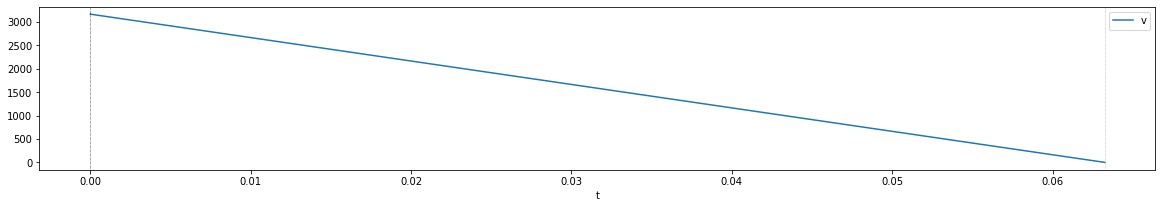

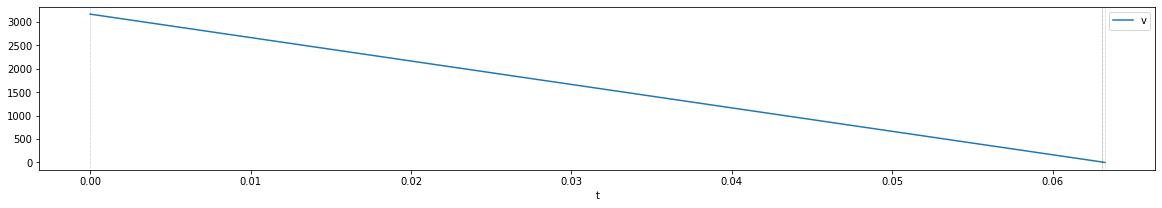

In [11]:
%reload_ext autoreload
%autoreload 2
%run startup.py
j = Joint(5_000, 50_000)

b = j.new_block(100, 5_000, 5_000).init()
#b.plan(b.t+.1)
plot_params(b)
print(b.t)
b.plan(.1)
plot_params(b)

<AxesSubplot:xlabel='t'>

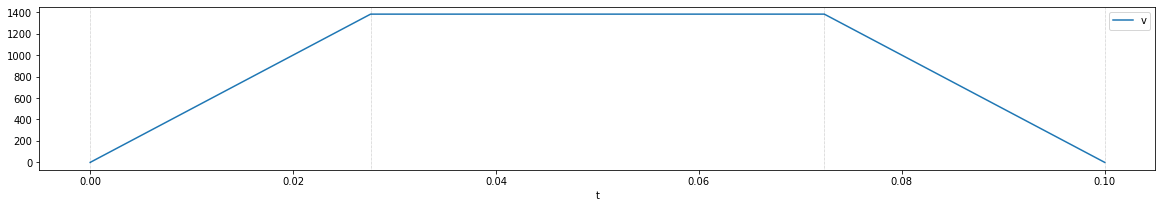

In [20]:
b = Block(x=100, t=0.1, t_a=0.09999969482421875, t_c=0.02, t_d=0.09999969482421875, x_a=249.9999999976717, x_c=100, 
          x_d=249.9999999976717, v_0=5000, v_c=0.0152587890625, v_1=0, d=1, 
          joint=Joint(v_max=5000, a_max=50000, small_x=500.0), flag='O', recalcs=0,  next=None, prior=None)
self = b
b.plan(b.t)
b.v_1 = b.v_
consistantize(b)
plot_params(b)


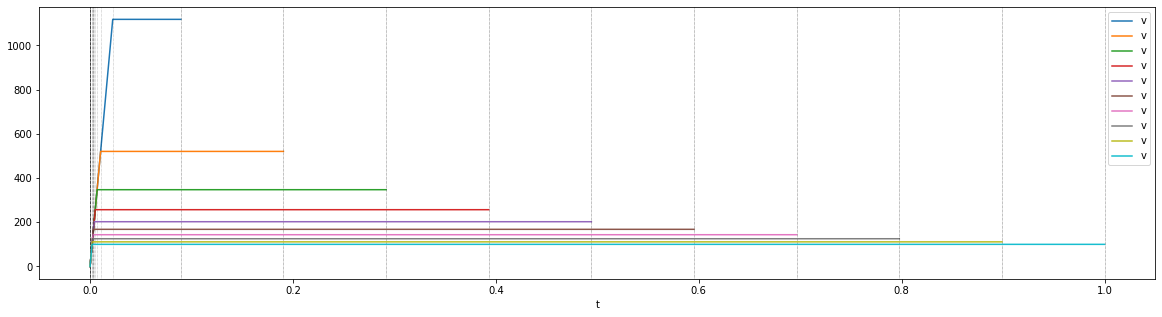

In [66]:
j = Joint(5_000, 50_000)

b = j.new_block(100, 0, 0).init()

fig, ax = plt.subplots(1, figsize = (20, 5))

for t in np.linspace(b.t, 1, num=10):
    b.plan_ramp(t)
    plot_params(b, ax=ax)



100.03128000000001


<AxesSubplot:xlabel='v_c'>

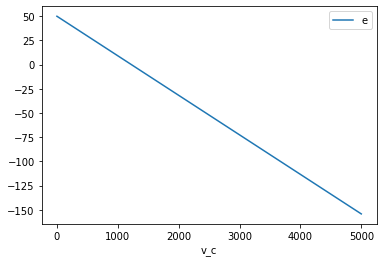

In [46]:
self = b = j.new_block(100, 100, 200).init()

def err(v_c):
    """Robust area calculation. May return wrong results for bad parameters, but
    will not throw exceptions"""

    x_a, t_a = accel_xt(self.v_0, self.v_c, a_max)

    t_c = max(self.t - t_a, 0)
    x_c = max(v_c, 0) * t_c

    return self.x-(x_a + x_c)

rows = [ dict(v_c=v_c, e=err(v_c)) for v_c in range(v_max) ]

df = pd.DataFrame(rows).set_index('v_c')
df.plot()
             
    
    

In [39]:
accel_xt(0, self.joint.v_max, self.joint.a_max)

(250.0, 0.1)

In [40]:
self.joint.small_x/2

250.0